# **Support Vector Machine**

## **Import Libraries**

In [1]:
import re
import html
import contractions
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import LinearSVC

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **Load Datasets**

In [3]:
df = ['D1CrackingArena', 'D2Twitter', 'D3DreamMarket', 'D4Garage4hackers', 'D5CrackingFire']

combined_df = pd.concat([pd.read_csv(f'datasets/{df[i]}.csv') for i in range(len(df))])

In [4]:
combined_df = combined_df[combined_df['label'] != 'Undecided']
combined_df['label'] = combined_df['label'].map({'YES': 1, 'NO': 0})

In [5]:
print(combined_df['label'].value_counts())

label
0    8359
1     882
Name: count, dtype: int64


## **Text Preprocessing**

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}

In [7]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
def preprocess(text):
    text = html.unescape(text)
    text = contractions.fix(text)
    text = re.sub(r'http\S+|www\S+|@\S+|\w+@\w+\\.\\w+', '', text)
    text = re.sub(r'\d+', '<NUM>', text)
    text = re.sub(r'[^\w\s_-]', '', text)
    text = text.lower()
    
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
              for (word, pos) in pos_tags]
    tokens = [word for word in tokens
              if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [9]:
combined_df['cleaned_content'] = combined_df['content'].apply(preprocess)

In [10]:
X = combined_df['cleaned_content']
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

## **Defining Pipeline**

In [11]:
svm = LinearSVC(C=0.1, class_weight='balanced', random_state=42)

In [12]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 1),
                        sublinear_tf=True, min_df=5, max_df=0.8)

In [13]:
smote = SMOTETomek(smote=SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42),
                   tomek=TomekLinks(sampling_strategy='auto'),
                   random_state=42)

In [14]:
pipeline = ImbPipeline([('tfidf', tfidf), ('smote', smote), ('svm', svm)])

## **Model Training**

In [15]:
params = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

In [16]:
grid_search = GridSearchCV(pipeline, params, cv=StratifiedKFold(n_splits=5),
                           scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.8,
                                                        max_features=5000,
                                                        min_df=5,
                                                        sublinear_tf=True)),
                                       ('smote',
                                        SMOTETomek(random_state=42,
                                                   smote=SMOTE(random_state=42,
                                                               sampling_strategy=0.5),
                                                   tomek=TomekLinks())),
                                       ('svm',
                                        LinearSVC(C=0.1,
                                                  class_weight='balanced',
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

In [17]:
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}


## **Model Evaluation**

In [18]:
def calculate_metrics(actual, predict, conf_matrix):
    tn, fp, _, _ = conf_matrix.ravel()

    accuracy = accuracy_score(actual, predict)
    precision = precision_score(actual, predict, average='macro')
    recall = recall_score(actual, predict, average='macro')
    specificity = tn / (tn + fp)
    f1 = f1_score(actual, predict, average='macro')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

    return metrics

def display_metrics(metrics):
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(12)}: {metric_value * 100:.2f}%")

In [19]:
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1673
           1       0.56      0.77      0.65       176

    accuracy                           0.92      1849
   macro avg       0.77      0.85      0.80      1849
weighted avg       0.94      0.92      0.93      1849



In [21]:
conf_matrix_train = confusion_matrix(y_test, y_pred)

metrics_train = calculate_metrics(y_test, y_pred, conf_matrix_train)
display_metrics(metrics_train)

Accuracy    : 92.16%
Precision   : 76.97%
Recall      : 85.50%
Specificity : 93.72%
F1-score    : 80.40%


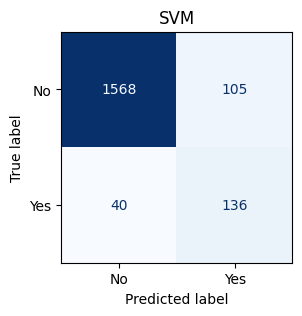

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No", "Yes"],
                                        ax=ax, colorbar=False, cmap='Blues')
ax.set_title("SVM")
plt.show()

## **Export Model**

In [23]:
import joblib
joblib.dump(model, 'svm.joblib')

['svm.joblib']